<a href="https://colab.research.google.com/github/godlejr/PytorchSkeleton/blob/main/pytorch_Assignment1_sequential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Data Preparation

**Data Set**  
$$X_{train} \in \mathcal{R}^{50000 \times 784}, Y_{train} \in \mathcal{Z}^{50000}$$  
$$X_{val} \in \mathcal{R}^{10000 \times 784}, Y_{val} \in \mathcal{Z}^{10000}$$  
$$X_{test} \in \mathcal{R}^{10000 \times 784}, Y_{test} \in \mathcal{Z}^{10000}$$

In [ ]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn


batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset =  datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

50000 10000 10000


### Inspecting Dataset

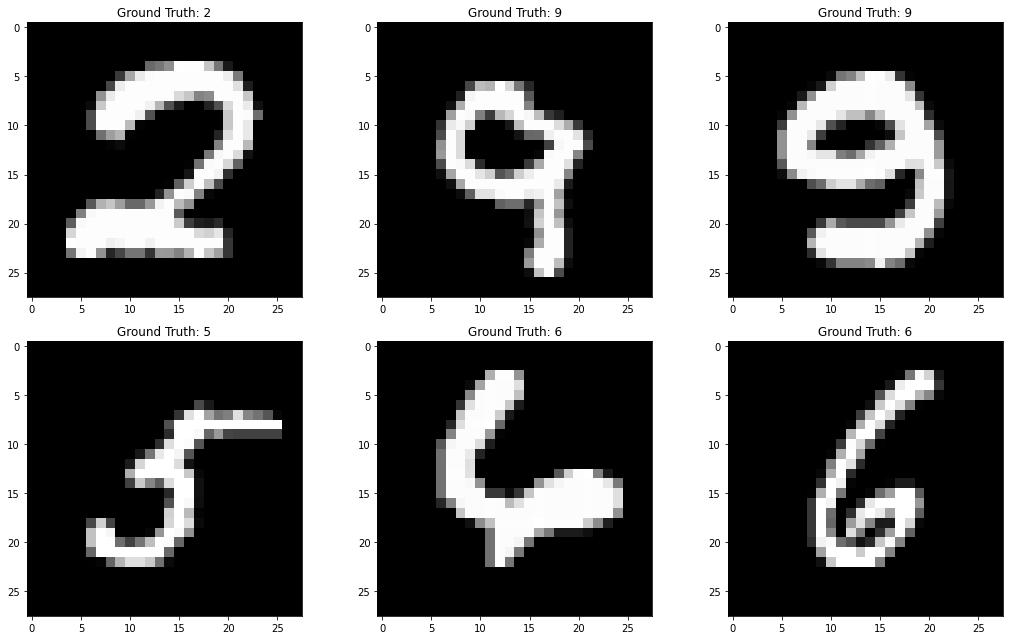

In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)  

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()

### 2. Model Architecture

In [ ]:

class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=784, out_features=10, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x

class MLPModel(nn.Module):
    def __init__(self,in_dim, out_dim, hid_unit, hid_count, use_bn):  
        super(MLPModel, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_unit = hid_unit
        self.hid_count = hid_count
        self.use_bn = use_bn
        self.act = nn.ReLU()

        self.layer = self._make_layers(self.in_dim, self.out_dim, self.hid_unit, self.hid_count, self.use_bn)

    def _make_layers(self, in_dim, out_dim, hid_unit, hid_count, use_bn):
        layers = []

        for i in range(hid_count-1):

            if i == 0 :
                layers.append(nn.Linear(in_features=in_dim,out_features=hid_unit))
            else:
                layers.append(nn.Linear(in_features=hid_unit,out_features=hid_unit))
              
                if use_bn:
                      layers.append(nn.BatchNorm1d(hid_unit))
            
                layers.append(self.act)

        #final
        layers.append(nn.Linear(in_features=hid_unit,out_features=out_dim))

        return nn.Sequential(*layers)

    '''Sequential vs ModuleList: 
    Sequential 은 통째로 모델이라 forward 함수에서 x 를 파라미터 한번만 넣으면 되지만 
    ModuleList는 for문으로 layer에 파라미터를 전달해야한다'''
    def forward(self,x):
        x = self.layer(x)
        return x

### 3. Cost Function Define (Loss Function Define)  

In [ ]:
cls_loss = nn.CrossEntropyLoss()

### 4. Train & Evaluation

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# ====== Construct Model ====== #
model = MLPModel(784,10,100,5,True)
print(model)
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ===== Construct Optimizer ====== #
lr = 0.005 
optimizer = optim.SGD(model.parameters(), lr=lr) 

list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 30
for i in range(epoch):
    
    # ====== Train ====== #
    train_loss = 0
    model.train() 
    
    for input_X, true_y in train_loader:
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 
        
        input_X = input_X.squeeze()

        input_X = input_X.view(-1, 784)
        
        pred_y = model(input_X)

        loss = cls_loss(pred_y.squeeze(), true_y)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.detach().numpy()

    train_loss = train_loss / len(train_loader)
    list_train_loss.append(train_loss)
    list_epoch.append(i)
    
    
    # ====== Validation ====== #
    val_loss = 0
    model.eval()
    #optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Validation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 
    

    with torch.no_grad(): # [21.01.05 코드 클린업] Validation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in val_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            pred_y = model(input_X)

            loss = cls_loss(pred_y.squeeze(), true_y)
            val_loss += loss.detach().numpy()
        val_loss = val_loss / len(val_loader)
        list_val_loss.append(val_loss)


    # ====== Evaluation ======= #
    correct = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Evaluation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 

    with torch.no_grad(): # [21.01.05 코드 클린업] Evaluation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in test_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
            correct += pred_y.eq(true_y).sum()

        acc = correct.numpy() / len(test_loader.dataset)
        list_acc.append(acc)
        list_acc_epoch.append(i)
    
    print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%'.format(i, train_loss, val_loss, acc*100))

MLPModel(
  (act): ReLU()
  (layer): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=100, out_features=100, bias=True)
    (8): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Linear(in_features=100, out_features=10, bias=True)
  )
)
Number of 110410 parameters
Epoch: 0, Train Loss: 1.041568912051218, Val Loss: 0.5550756903388833, Test Acc: 90.36999999999999%
Epoch: 1, Train Loss: 0.4421956308967317, Val Loss: 0.34603332001951675, Test Acc: 92.78999999999999%
Epoch: 2, Train Loss: 0.30913673127856095, Val Loss: 0.26556060133101067, Test Acc: 93.

### 5. Report Experiment 

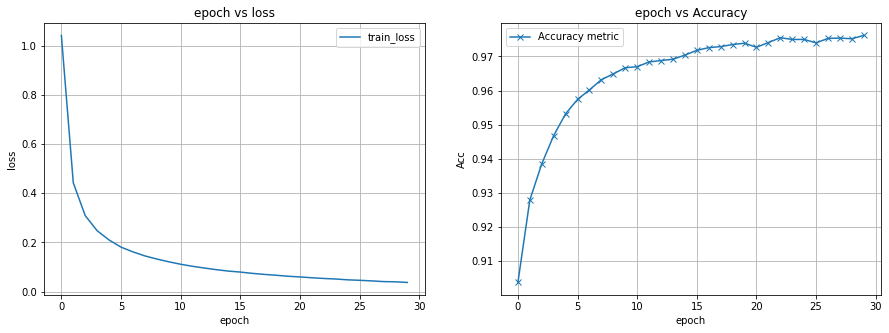

In [ ]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
#ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()